<a href="https://colab.research.google.com/github/puginarug/streamlit_cell_migration/blob/main/cell_migration_simulation_extended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhanced Object-Oriented Cell Migration Simulation

This notebook simulates cell migration in 2D with the following features:

- **Initial Positions**: All cells start along the vertical line at `x=0`, evenly spaced in `y`.
- **Chemotaxis to a Line Source**: A chemical source is a vertical line at `x = source_x`. Cells bias movement toward this line based on local gradient.
- **Persistence**: Cells have a probability of continuing in their previous direction.
- **Cell–Cell Interaction**: When cells come within a defined interaction radius, they deflect by 90° to avoid collisions.
- **Analysis**: Methods to compute Mean Squared Displacement (MSD) and Velocity Autocorrelation (VAC).

Structure:
1. `Gradient` class for managing a line source gradient and providing local angle distributions.
2. `Cell` class with persistence and signal sensitivity.
3. `Simulation` class to initialize positions on `x=0`, run dynamics, and analyze results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Gradient Class

Represents a chemical line source at `x = source_x`. The gradient is linear: cells measure the direction toward the line.

Attributes:
- `source_x`: x-coordinate of the vertical source line.

Methods:
- `gradient_vector(x, y)`: Returns a vector pointing toward the source line, whose magnitude decays linearly from `max_strength` at `x = source_x` down to 0 at `x = 0` (or beyond).  
- `gradient_angle(x, y)`: Returns the direction (radians) of that vector.


In [6]:
class Gradient:
    def __init__(self, source_x=10.0, max_strength=1.0):
        self.source_x = source_x
        self.max_strength = max_strength

    def gradient_vector(self, x, y):
        # Vector toward the source line at (source_x, y)
        dx = self.source_x - x
        dy = 0.0
        # Linear decay: magnitude = max_strength * (dx / source_x)
        # ensure non-negative
        mag = max(0.0, self.max_strength * (dx / self.source_x))
        # unit direction
        if dx == 0:
            ux = 1.0
        else:
            ux = dx / abs(dx)
        return np.array([ux * mag, 0.0])

    def gradient_angle(self, x, y):
        vec = self.gradient_vector(x, y)
        return np.arctan2(vec[1], vec[0])

Attributes:
- `persistence` (0–1): Probability to maintain the previous direction.
- `signal_sensitivity` (0–1): Standard deviation of the normal distribution around the gradient angle (lower = stronger bias).
- `interaction_radius`: Distance threshold for neighbor-induced deflection.

Methods:
- `step(dt, speed, gradient, neighbors)`:
  1. Compute the gradient direction at the cell's position.
  2. Draw a candidate angle from a normal distribution centered on the gradient angle, with standard deviation `sigma = (1 - signal_sensitivity) * pi`.
  3. With probability `persistence`, keep the last angle; otherwise adopt the candidate.
  4. If a neighbor is within `interaction_radius`, add ±90° deflection.
  5. Update velocity and position, record angle.

In [3]:
class Cell:
    def __init__(self, cell_id, x0=0.0, y0=0.0,
                 persistence=0.5, signal_sensitivity=0.5,
                 interaction_radius=1.0):
        self.id = cell_id
        self.positions = [(x0, y0)]
        self.velocities = []
        self.angles = []
        self.persistence = persistence
        self.signal_sensitivity = signal_sensitivity
        self.interaction_radius = interaction_radius
        # Initialize with random direction
        self.angles.append(np.random.uniform(0, 2*np.pi))

    def step(self, dt, speed, gradient, neighbors):
        x, y = self.positions[-1]

        # 1. Gradient angle
        grad_theta = gradient.gradient_angle(x, y)

        # 2. Candidate from normal distribution
        sigma = (1 - self.signal_sensitivity) * np.pi
        theta_cand = np.random.normal(loc=grad_theta, scale=sigma)

        # 3. Persistence: keep last or candidate
        if np.random.rand() < self.persistence:
            theta = self.angles[-1]
        else:
            theta = theta_cand

        # 4. Cell–cell interaction
        if self.interaction_radius > 0:
            for nbr in neighbors:
                dx = nbr.positions[-1][0] - x
                dy = nbr.positions[-1][1] - y
                if np.hypot(dx, dy) < self.interaction_radius:
                    theta += (np.pi/2) * np.sign(np.random.randn())
                    break

        # 5. Update motion
        vx = speed * np.cos(theta)
        vy = speed * np.sin(theta)
        x_new = x + vx * dt
        y_new = y + vy * dt

        # Record
        self.velocities.append((vx, vy))
        self.positions.append((x_new, y_new))
        self.angles.append(theta)

## Simulation Class

Initializes cells along `x=0`, evenly spaced in `y` over range `[-L, L]`.

Parameters:
- `gradient`: `Gradient` instance.
- `n_cells`, `dt`, `speed`, `persistence`, `signal_sensitivity`, `interaction_radius`, `line_length`.

Methods:
- `run(n_steps)`, `get_positions_array()`, `compute_msd()`, `compute_vac()`.

In [7]:
class Simulation:
    def __init__(self, gradient=None,
                 n_cells=10, dt=1.0, speed=1.0,
                 persistence=0.5, signal_sensitivity=0.5,
                 interaction_radius=1.0, line_length=10.0):
        self.gradient = gradient or Gradient()
        self.dt = dt
        self.speed = speed
        ys = np.linspace(-line_length/2, line_length/2, n_cells)
        self.cells = [Cell(i, x0=0.0, y0=ys[i],
                           persistence=persistence,
                           signal_sensitivity=signal_sensitivity,
                           interaction_radius=interaction_radius)
                      for i in range(n_cells)]
        self.n_steps = 0

    def run(self, n_steps):
        self.n_steps = n_steps
        for _ in range(n_steps):
            for cell in self.cells:
                neighbors = [c for c in self.cells if c is not cell]
                cell.step(self.dt, self.speed, self.gradient, neighbors)

    def get_positions_array(self):
        return np.array([cell.positions for cell in self.cells])

    def get_velocities_array(self):
        return np.array([cell.velocities for cell in self.cells])

    def compute_msd(self, max_lag=None):
        pos = self.get_positions_array()
        n_cells, T, _ = pos.shape
        max_lag = max_lag or (T - 1)
        msd = np.zeros(max_lag)
        for lag in range(1, max_lag + 1):
            disp2 = []
            for c in range(n_cells):
                for t in range(T-lag):
                    dx = pos[c,t+lag,0] - pos[c,t,0]
                    dy = pos[c,t+lag,1] - pos[c,t,1]
                    disp2.append(dx*dx + dy*dy)
            msd[lag-1] = np.mean(disp2)
        return msd

    def compute_directional_ac(self, max_lag=None):

        """Compute the directional velocity autocorrelation:
        VAC(τ) = < (v(t) · v(t+τ)) / (|v(t)| * |v(t+τ)| ) >,
        normalized so that VAC(0) = 1."""

        vel = self.get_velocities_array()
        n_cells, Tm, _ = vel.shape
        max_lag = max_lag or (Tm - 1)
        # include tau=0
        vac = np.zeros(max_lag + 1)
        vac[0] = 1.0
        for lag in range(1, max_lag + 1):
            acs = []
            for c in range(n_cells):
                for t in range(Tm - lag):
                    v0 = vel[c, t]
                    v1 = vel[c, t + lag]
                    norm = np.linalg.norm(v0) * np.linalg.norm(v1)
                    if norm > 0:
                        acs.append(np.dot(v0, v1) / norm)
            vac[lag] = np.mean(acs) if acs else 0.0
        return vac

## Example Usage and Visualization

In [20]:
# Example usage
grad = Gradient(source_x=30.0)
sim = Simulation(gradient=grad,
                 n_cells=30, dt=1, speed=1.0,
                 persistence=0.2, signal_sensitivity=0.5,
                 interaction_radius=0, line_length=20.0)

sim.run(n_steps=100)

In [21]:
# Get positions, angles, MSD, and VAC
pos = sim.get_positions_array()
angles = np.mod(np.array([cell.angles for cell in sim.cells]) + np.pi, 2 * np.pi) - np.pi # Normalize angles to [-pi, pi]
msd = sim.compute_msd()
dac = sim.compute_directional_ac()

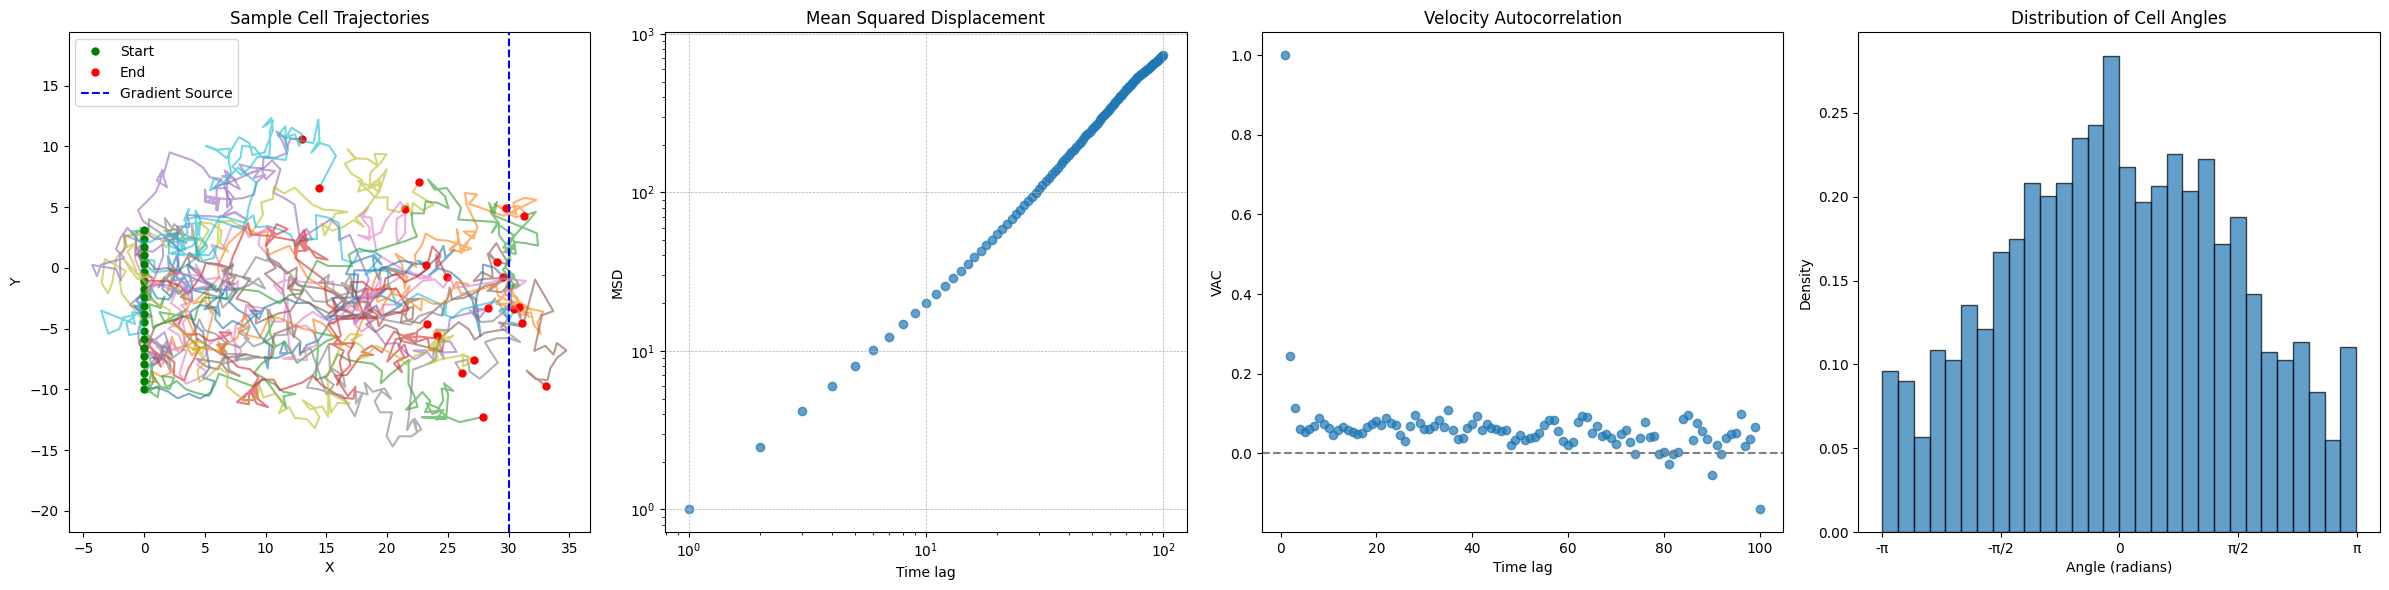

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Trajectories
for c in range(20):
    traj = pos[c]
    axes[0].plot(traj[:, 0], traj[:, 1], alpha=0.6)
    # plot start and end points
    axes[0].plot(traj[0, 0], traj[0, 1], 'o', color='green', markersize=5, label='Start' if c == 0 else "")
    axes[0].plot(traj[-1, 0], traj[-1, 1], 'o', color='red', markersize=5, label='End' if c == 0 else "")

# add gradient source line
axes[0].axvline(x=grad.source_x, color='blue', linestyle='--', label='Gradient Source')
axes[0].legend()
axes[0].set_title('Sample Cell Trajectories')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].axis('equal')

# MSD
lags = np.arange(1, len(msd) + 1) * sim.dt
axes[1].scatter(lags, msd, alpha=0.7)
axes[1].set_title('Mean Squared Displacement')
axes[1].set_xlabel('Time lag')
axes[1].set_ylabel('MSD')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True, which='major', linestyle='--', linewidth=0.5)

# VAC
axes[2].scatter(lags, dac, alpha=0.7)
axes[2].set_title('Velocity Autocorrelation')
axes[2].set_xlabel('Time lag')
axes[2].set_ylabel('VAC')
axes[2].axhline(0, color='gray', linestyle='--')

# Angles
axes[3].hist(angles.flatten(), bins=30, density=True, alpha=0.7, edgecolor='black')
axes[3].set_title('Distribution of Cell Angles')
axes[3].set_xlabel('Angle (radians)')
axes[3].set_ylabel('Density')
axes[3].set_xticks(np.arange(-np.pi, np.pi + 0.1, np.pi / 2))
axes[3].set_xticklabels(['-π', '-π/2', '0', 'π/2', 'π'])

plt.tight_layout()
plt.show()